## Problem Statement
You are provided with a dataset containing various attributes of different wine samples. The goal of this assignment is to perform cluster analysis using the K-means algorithm to identify natural groupings in the data based on the attributes provided.

## Dataset Overview
The dataset consists of the following columns:
1. **Alcohol**: Alcohol content in the wine sample.
2. **Malic_Acid**: Amount of malic acid in the wine.
3. **Ash**: Ash content in the wine.
4. **Ash_Alcalinity**: Alkalinity of ash in the wine.
5. **Magnesium**: Magnesium content in the wine.
6. **Total_Phenols**: Total phenols content in the wine.
7. **Flavanoids**: Flavonoid content in the wine.
8. **Nonflavanoid_Phenols**: Non-flavonoid phenol content in the wine.
9. **Proanthocyanins**: Proanthocyanin content in the wine.
10. **Color_Intensity**: Intensity of the color of the wine.
11. **Hue**: Hue of the wine.
12. **OD280**: Ratio of OD280/OD315 of diluted wines.
13. **Proline**: Proline content in the wine.

In [1]:
# install missing package for outlier detection (run once in the notebook)
%pip install pyod

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
from pyod.models.iforest import IForest

import warnings as war

war.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('datasets/WineData.csv')
df.head()

,Unnamed: 0,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Tasks

### Task 1: Data Preprocessing
- Handle any missing values if present.
- Scale the data using `StandardScaler` or `MinMaxScaler` since K-means is sensitive to the scale of features.
- Remove any unnecessary columns that don't contribute to clustering (e.g., index column if not relevant).

In [4]:
df.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [5]:
# numeric and objective columns
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
object_columns = df.select_dtypes(include=['object']).columns
print(f'Numeric columns : {num_columns}\n\nObject Columns : {object_columns}')

Numeric columns : Index(['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
       'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
       'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'],
      dtype='object')

Object Columns : Index([], dtype='object')


In [6]:
df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [7]:
df_exp = df.copy()
df_exp.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
df_exp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [9]:
# The Isolation Forest for detecting the Anomalies, such as capturing the Outliers
iforest_model = IForest()
iforest_model.fit(df_exp)
outliers = iforest_model.labels_
df_exp['Outlier'] = outliers
df_exp['Outlier'].value_counts()

Outlier
0    160
1     18
Name: count, dtype: int64

In [10]:
df_exp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,0


In [11]:
# Remove samples, which holds the outliers and labeled as 1
for i, j in enumerate(df_exp['Outlier']):
    if j == 1:
        df_exp = df_exp.drop(i)
df_exp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,0


In [12]:
df_exp['Outlier'].value_counts()

Outlier
0    160
Name: count, dtype: int64

In [13]:
df_exp_two = df_exp.copy()
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Outlier
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0


In [14]:
df_exp_two = df_exp_two.drop('Outlier', axis=1)
df_exp_two

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [15]:
# Evaluation the Correlation Matrix
correlated = df_exp_two.corr()
correlated

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Alcohol,1.000000,0.118361,0.214430,-0.318281,0.467276,0.304728,0.271595,-0.222992,0.215655,0.513627,-0.036940,0.120115,0.645634
Malic_Acid,0.118361,1.000000,0.175556,0.309334,0.042936,-0.349439,-0.457745,0.328194,-0.243926,0.317805,-0.565039,-0.398506,-0.163200
Ash,0.214430,0.175556,1.000000,0.370140,0.420033,0.097087,0.044800,0.150069,0.046705,0.203903,-0.032374,-0.040061,0.266423
Ash_Alcanity,-0.318281,0.309334,0.370140,1.000000,-0.181445,-0.420693,-0.455882,0.389438,-0.229893,-0.001347,-0.286487,-0.374971,-0.446763
Magnesium,0.467276,0.042936,0.420033,-0.181445,1.000000,0.243886,0.217326,-0.211994,0.125189,0.368408,-0.035863,0.018124,0.459528
Total_Phenols,0.304728,-0.349439,0.097087,-0.420693,0.243886,1.000000,0.874645,-0.505699,0.636341,-0.150356,0.481602,0.710262,0.476862
Flavanoids,0.271595,-0.457745,0.044800,-0.455882,0.217326,0.874645,1.000000,-0.615347,0.735112,-0.252141,0.589620,0.794954,0.482096
Nonflavanoid_Phenols,-0.222992,0.328194,0.150069,0.389438,-0.211994,-0.505699,-0.615347,1.000000,-0.413676,0.090802,-0.275498,-0.518997,-0.316166
Proanthocyanins,0.215655,-0.243926,0.046705,-0.229893,0.125189,0.636341,0.735112,-0.413676,1.000000,-0.095251,0.348386,0.591986,0.344275
Color_Intensity,0.513627,0.317805,0.203903,-0.001347,0.368408,-0.150356,-0.252141,0.090802,-0.095251,1.000000,-0.545260,-0.474735,0.302028


<Axes: >

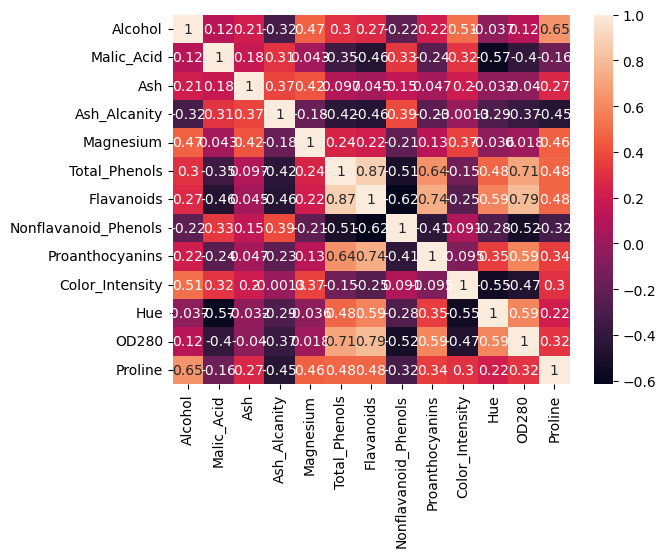

In [16]:
# Heat of Correlation Matrix
sns.heatmap(correlated, annot=True)

In [17]:
# Finding the Highly Correlated features
high_corr_columns = []
high_corr_rows = []
hig_corr = []

for i in correlated.columns:
    for j in correlated.columns:
        if i!=j:
            if correlated.loc[i, j] > 0.7:
                high_corr_columns.append(i)
                high_corr_rows.append(j)
                hig_corr.append(correlated.loc[i, j])
               
data_high_corr = {
    'Feature_1' : high_corr_columns,
    'Feature_2' : high_corr_rows,
    'Correlation' : hig_corr
}

high_corr_features = pd.DataFrame(data_high_corr)
high_corr_features
                

,Feature_1,Feature_2,Correlation
0,Total_Phenols,Flavanoids,0.874645
1,Total_Phenols,OD280,0.710262
2,Flavanoids,Total_Phenols,0.874645
3,Flavanoids,Proanthocyanins,0.735112
4,Flavanoids,OD280,0.794954
5,Proanthocyanins,Flavanoids,0.735112
6,OD280,Total_Phenols,0.710262
7,OD280,Flavanoids,0.794954


In [18]:
high_corr_features['Feature_1'].value_counts()

Feature_1
Flavanoids         3
Total_Phenols      2
OD280              2
Proanthocyanins    1
Name: count, dtype: int64

<Axes: >

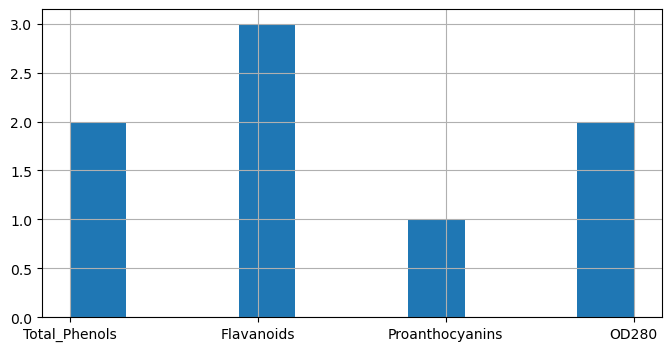

In [19]:
high_corr_features['Feature_1'].hist(figsize=(8, 4), bins=10)

In [20]:
high_corr_features['Feature_2'].value_counts()

Feature_2
Flavanoids         3
OD280              2
Total_Phenols      2
Proanthocyanins    1
Name: count, dtype: int64

<Axes: >

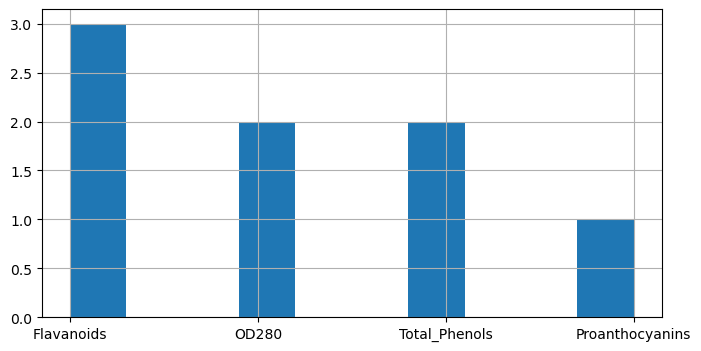

In [21]:
high_corr_features['Feature_2'].hist(figsize=(8, 4), bins=10)

In [22]:
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [23]:
# Remove the Highly Correlated features and 
# reserved the Highly contaminated features
df_exp_two.drop(columns=['Total_Phenols', 
                         'OD280', 
                         'Proanthocyanins'], inplace=True)
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
0,14.23,1.71,2.43,15.6,127,3.06,0.28,5.64,1.04,1065
1,13.20,1.78,2.14,11.2,100,2.76,0.26,4.38,1.05,1050
2,13.16,2.36,2.67,18.6,101,3.24,0.30,5.68,1.03,1185
4,13.24,2.59,2.87,21.0,118,2.69,0.39,4.32,1.04,735
5,14.20,1.76,2.45,15.2,112,3.39,0.34,6.75,1.05,1450


In [24]:
# Feature Transformation using StandardScaler and 
# Implemented through Pipeline 
preprocess = Pipeline([
    ('numeric', StandardScaler())
])
preprocess_transformed = preprocess.fit_transform(df_exp_two)
df_scaled = pd.DataFrame(preprocess_transformed, columns=df_exp_two.columns)
df_scaled.head()


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
0,1.602134,-0.589682,0.227728,-1.323774,2.348262,1.131556,-0.703496,0.282946,0.410172,1.089850
1,0.249720,-0.526765,-0.925830,-2.793010,0.114776,0.815534,-0.866271,-0.295808,0.456052,1.040032
2,0.197200,-0.005449,1.182398,-0.322022,0.197498,1.321169,-0.540720,0.301320,0.364291,1.488393
3,0.302241,0.201280,1.977955,0.479380,1.603767,0.741796,0.191770,-0.323367,0.410172,-0.006144
4,1.562743,-0.544741,0.307284,-1.457341,1.107437,1.479180,-0.215169,0.792801,0.456052,2.368509


In [25]:
df_exp_two.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Flavanoids              0
Nonflavanoid_Phenols    0
Color_Intensity         0
Hue                     0
Proline                 0
dtype: int64

### Task 2: Determine the Optimal Number of Clusters
- Use the **Elbow method** to determine the optimal number of clusters.
- Visualize the results using a line plot of the **Within-Cluster Sum of Squares (WCSS)** against the number of clusters.

In [26]:
kmeans = KMeans()
kmeans.fit_predict(df_scaled)

array([6, 6, 1, 1, 6, 6, 1, 6, 6, 6, 6, 6, 1, 1, 1, 6, 6, 1, 6, 1, 1, 1,
       1, 6, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 1, 6, 1, 6, 1, 6, 1, 6, 5, 5, 7, 7, 2, 2, 7, 7, 5, 2, 2, 2,
       2, 7, 7, 2, 2, 7, 7, 2, 3, 2, 7, 2, 2, 2, 2, 2, 2, 5, 2, 2, 7, 7,
       2, 7, 7, 2, 2, 7, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 5, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 0, 0, 0, 0, 5, 5, 3, 3, 5, 3, 3, 4, 3, 3, 0, 4, 4,
       4, 0, 0, 0, 0, 4, 5, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 0, 0, 5, 4,
       4, 4, 4, 4, 4, 4], dtype=int32)

In [27]:
# The Centroids of Clusters
kmeans.cluster_centers_

array([[-0.01765866,  0.5575394 ,  0.48447654,  0.88918787,  1.03975523,
        -0.8526785 , -0.83667567,  1.09428758, -1.33745815, -0.48167872],
       [ 0.65789927, -0.39389589,  1.15299655, -0.21603911,  0.78374305,
         0.88331836, -0.32486553,  0.03331131,  0.74330392,  1.16926947],
       [-1.07643236, -0.31712119, -0.21520373,  0.4820876 , -0.70573339,
         0.08868364, -0.02159801, -1.0396715 ,  0.32783474, -0.81669493],
       [-0.34618978,  1.10770556,  0.98656802,  1.19858686, -0.12066231,
        -1.02063418,  1.48771391, -0.19616861, -0.30626995, -0.51122109],
       [ 0.4243525 ,  1.17605049,  0.02685007,  0.44598842, -0.17474957,
        -1.36501699,  0.87135796,  1.51555446, -1.43881234, -0.23364596],
       [-0.42230836, -0.28653479, -0.67631443, -0.37059139, -0.43419487,
        -1.02505406,  1.54576674, -0.10748287, -0.48241255, -0.59429737],
       [ 1.14170053, -0.21157861, -0.1899394 , -1.12898863,  0.62213604,
         1.08029006, -0.84728074,  0.27452535

In [28]:
df_scaled.shape

(160, 10)

In [29]:
# Calculating the Within-Cluster Sum of Squares (WCSS) for each Cluster
wcss = []
for i in range(1, 10):
    kmeans_each = KMeans(n_clusters=i)
    kmeans_each.fit_predict(df_scaled.values)
    wcss.append(kmeans_each.inertia_)
wcss

[1600.0,
 1185.4502017274817,
 849.052669864454,
 791.338259810663,
 737.9218880506585,
 697.4429221836115,
 674.7694345880111,
 625.12221733885,
 598.4725274311636]

In [30]:
# Evaluting the Silhouette Score for each Cluster, 
# for obeserving how Datapoints are fitted within Clusters
labels = []
sil_score = []
cluster_range = range(2, 10)
for i in cluster_range:
    kmeans_each = KMeans(n_clusters=i, random_state=42)
    lbls = kmeans_each.fit_predict(df_scaled.values)
    score = silhouette_score(df_scaled, lbls)
    labels.append(lbls) 
    sil_score.append(score)

for l, s in zip(cluster_range, sil_score):
    print(f'Cluster {l} -> Score : {s}')

Cluster 2 -> Score : 0.24866034189415948
Cluster 3 -> Score : 0.30879275560468733
Cluster 4 -> Score : 0.25825959634267104
Cluster 5 -> Score : 0.23079397025207307
Cluster 6 -> Score : 0.16149236637437786
Cluster 7 -> Score : 0.13108283149188088
Cluster 8 -> Score : 0.1512905474001564
Cluster 9 -> Score : 0.13252647711365573


In [31]:
print(f"Number of WCSS : {len(wcss)}")

Number of WCSS : 9


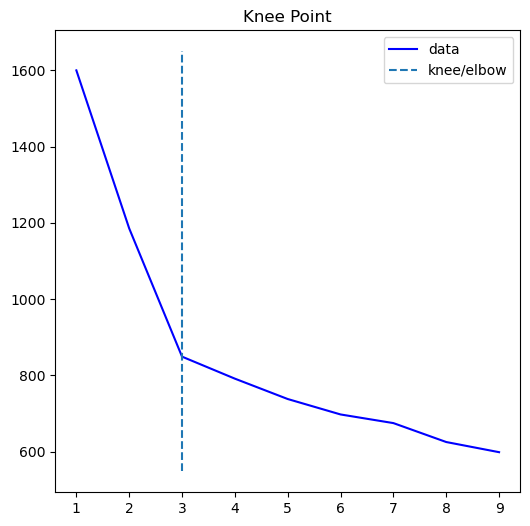

In [ ]:
# Finding the KneePoint for Optimal Cluster Number
knee = KneeLocator(range(1, 10), wcss, curve='convex', direction='decreasing')
knee.plot_knee()

### Task 3: K-means Clustering
- Apply K-means clustering using the optimal number of clusters obtained from the Elbow method.
- Assign cluster labels to each data point and create a new column in the dataset with these labels.



In [33]:
# Predict Clusters through Optimal Number
optimal_cluster_num = 3
km_optimal = KMeans(n_clusters = optimal_cluster_num)
predicted = km_optimal.fit_predict(df_scaled)
predicted

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [34]:
predicted.shape

(160,)

In [35]:
df_exp_two['clusters'] = predicted
df_exp_two.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline,clusters
0,14.23,1.71,2.43,15.6,127,3.06,0.28,5.64,1.04,1065,2
1,13.20,1.78,2.14,11.2,100,2.76,0.26,4.38,1.05,1050,2
2,13.16,2.36,2.67,18.6,101,3.24,0.30,5.68,1.03,1185,2
4,13.24,2.59,2.87,21.0,118,2.69,0.39,4.32,1.04,735,2
5,14.20,1.76,2.45,15.2,112,3.39,0.34,6.75,1.05,1450,2


In [36]:
df_scaled['clusters'] = predicted
df_scaled.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline,clusters
0,1.602134,-0.589682,0.227728,-1.323774,2.348262,1.131556,-0.703496,0.282946,0.410172,1.089850,2
1,0.249720,-0.526765,-0.925830,-2.793010,0.114776,0.815534,-0.866271,-0.295808,0.456052,1.040032,2
2,0.197200,-0.005449,1.182398,-0.322022,0.197498,1.321169,-0.540720,0.301320,0.364291,1.488393,2
3,0.302241,0.201280,1.977955,0.479380,1.603767,0.741796,0.191770,-0.323367,0.410172,-0.006144,2
4,1.562743,-0.544741,0.307284,-1.457341,1.107437,1.479180,-0.215169,0.792801,0.456052,2.368509,2


In [37]:
df_exp_two['clusters'].value_counts()

clusters
0    60
2    55
1    45
Name: count, dtype: int64

### Task 4: Cluster Analysis
- Analyze the clusters by comparing the mean values of each feature within each cluster.
- Visualize the clusters using a pairplot or scatterplot for selected features to understand the separations visually.



In [38]:
# Original DataFrames of Clusters
df_cluster_origin_one = df_exp_two[df_exp_two['clusters'] == 0]
df_cluster_origin_two = df_exp_two[df_exp_two['clusters'] == 1]
df_cluster_origin_three = df_exp_two[df_exp_two['clusters'] == 2]

In [39]:
# Scaled DataFrames of Clusters
df_cluster_scaled_one = df_scaled[df_scaled['clusters'] == 0]
df_cluster_scaled_two = df_scaled[df_scaled['clusters'] == 1]
df_cluster_scaled_three = df_scaled[df_scaled['clusters'] == 2]

In [40]:
df_cluster_origin_one.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline,clusters
60,12.33,1.10,2.28,16.0,101,1.09,0.63,3.27,1.25,680,0
61,12.64,1.36,2.02,16.8,100,1.41,0.53,5.75,0.98,450,0
62,13.67,1.25,1.92,18.0,94,1.79,0.32,3.80,1.23,630,0
63,12.37,1.13,2.16,19.0,87,3.10,0.19,4.45,1.22,420,0
64,12.17,1.45,2.53,19.0,104,1.75,0.45,2.95,1.45,355,0


In [41]:
# grouping clusters by calculating mean 
mean_of_clusters = df_exp_two.groupby('clusters').mean()
mean_of_clusters

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
clusters,,,,,,,,,,
0,12.312167,1.835500,2.239,20.036667,90.133333,2.031500,0.375000,3.124500,1.050600,505.100000
1,13.106222,3.496222,2.442,21.644444,99.555556,0.814444,0.450222,7.171111,0.695556,625.333333
2,13.692000,2.020182,2.462,17.347273,107.090909,2.894364,0.288545,5.339455,1.050182,1080.909091


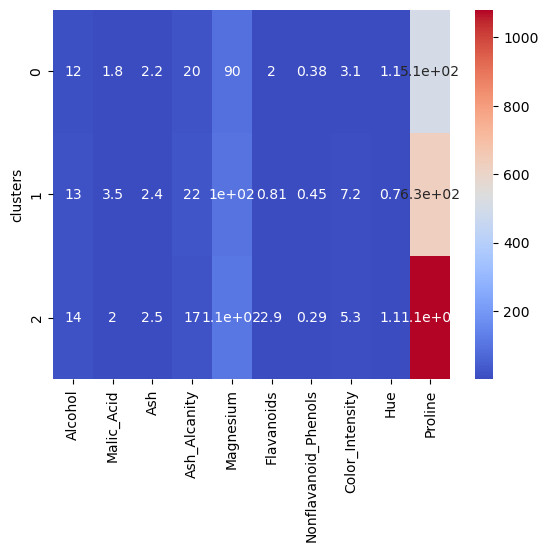

In [42]:
sns.heatmap(mean_of_clusters, annot=True, cmap='coolwarm')
plt.show()

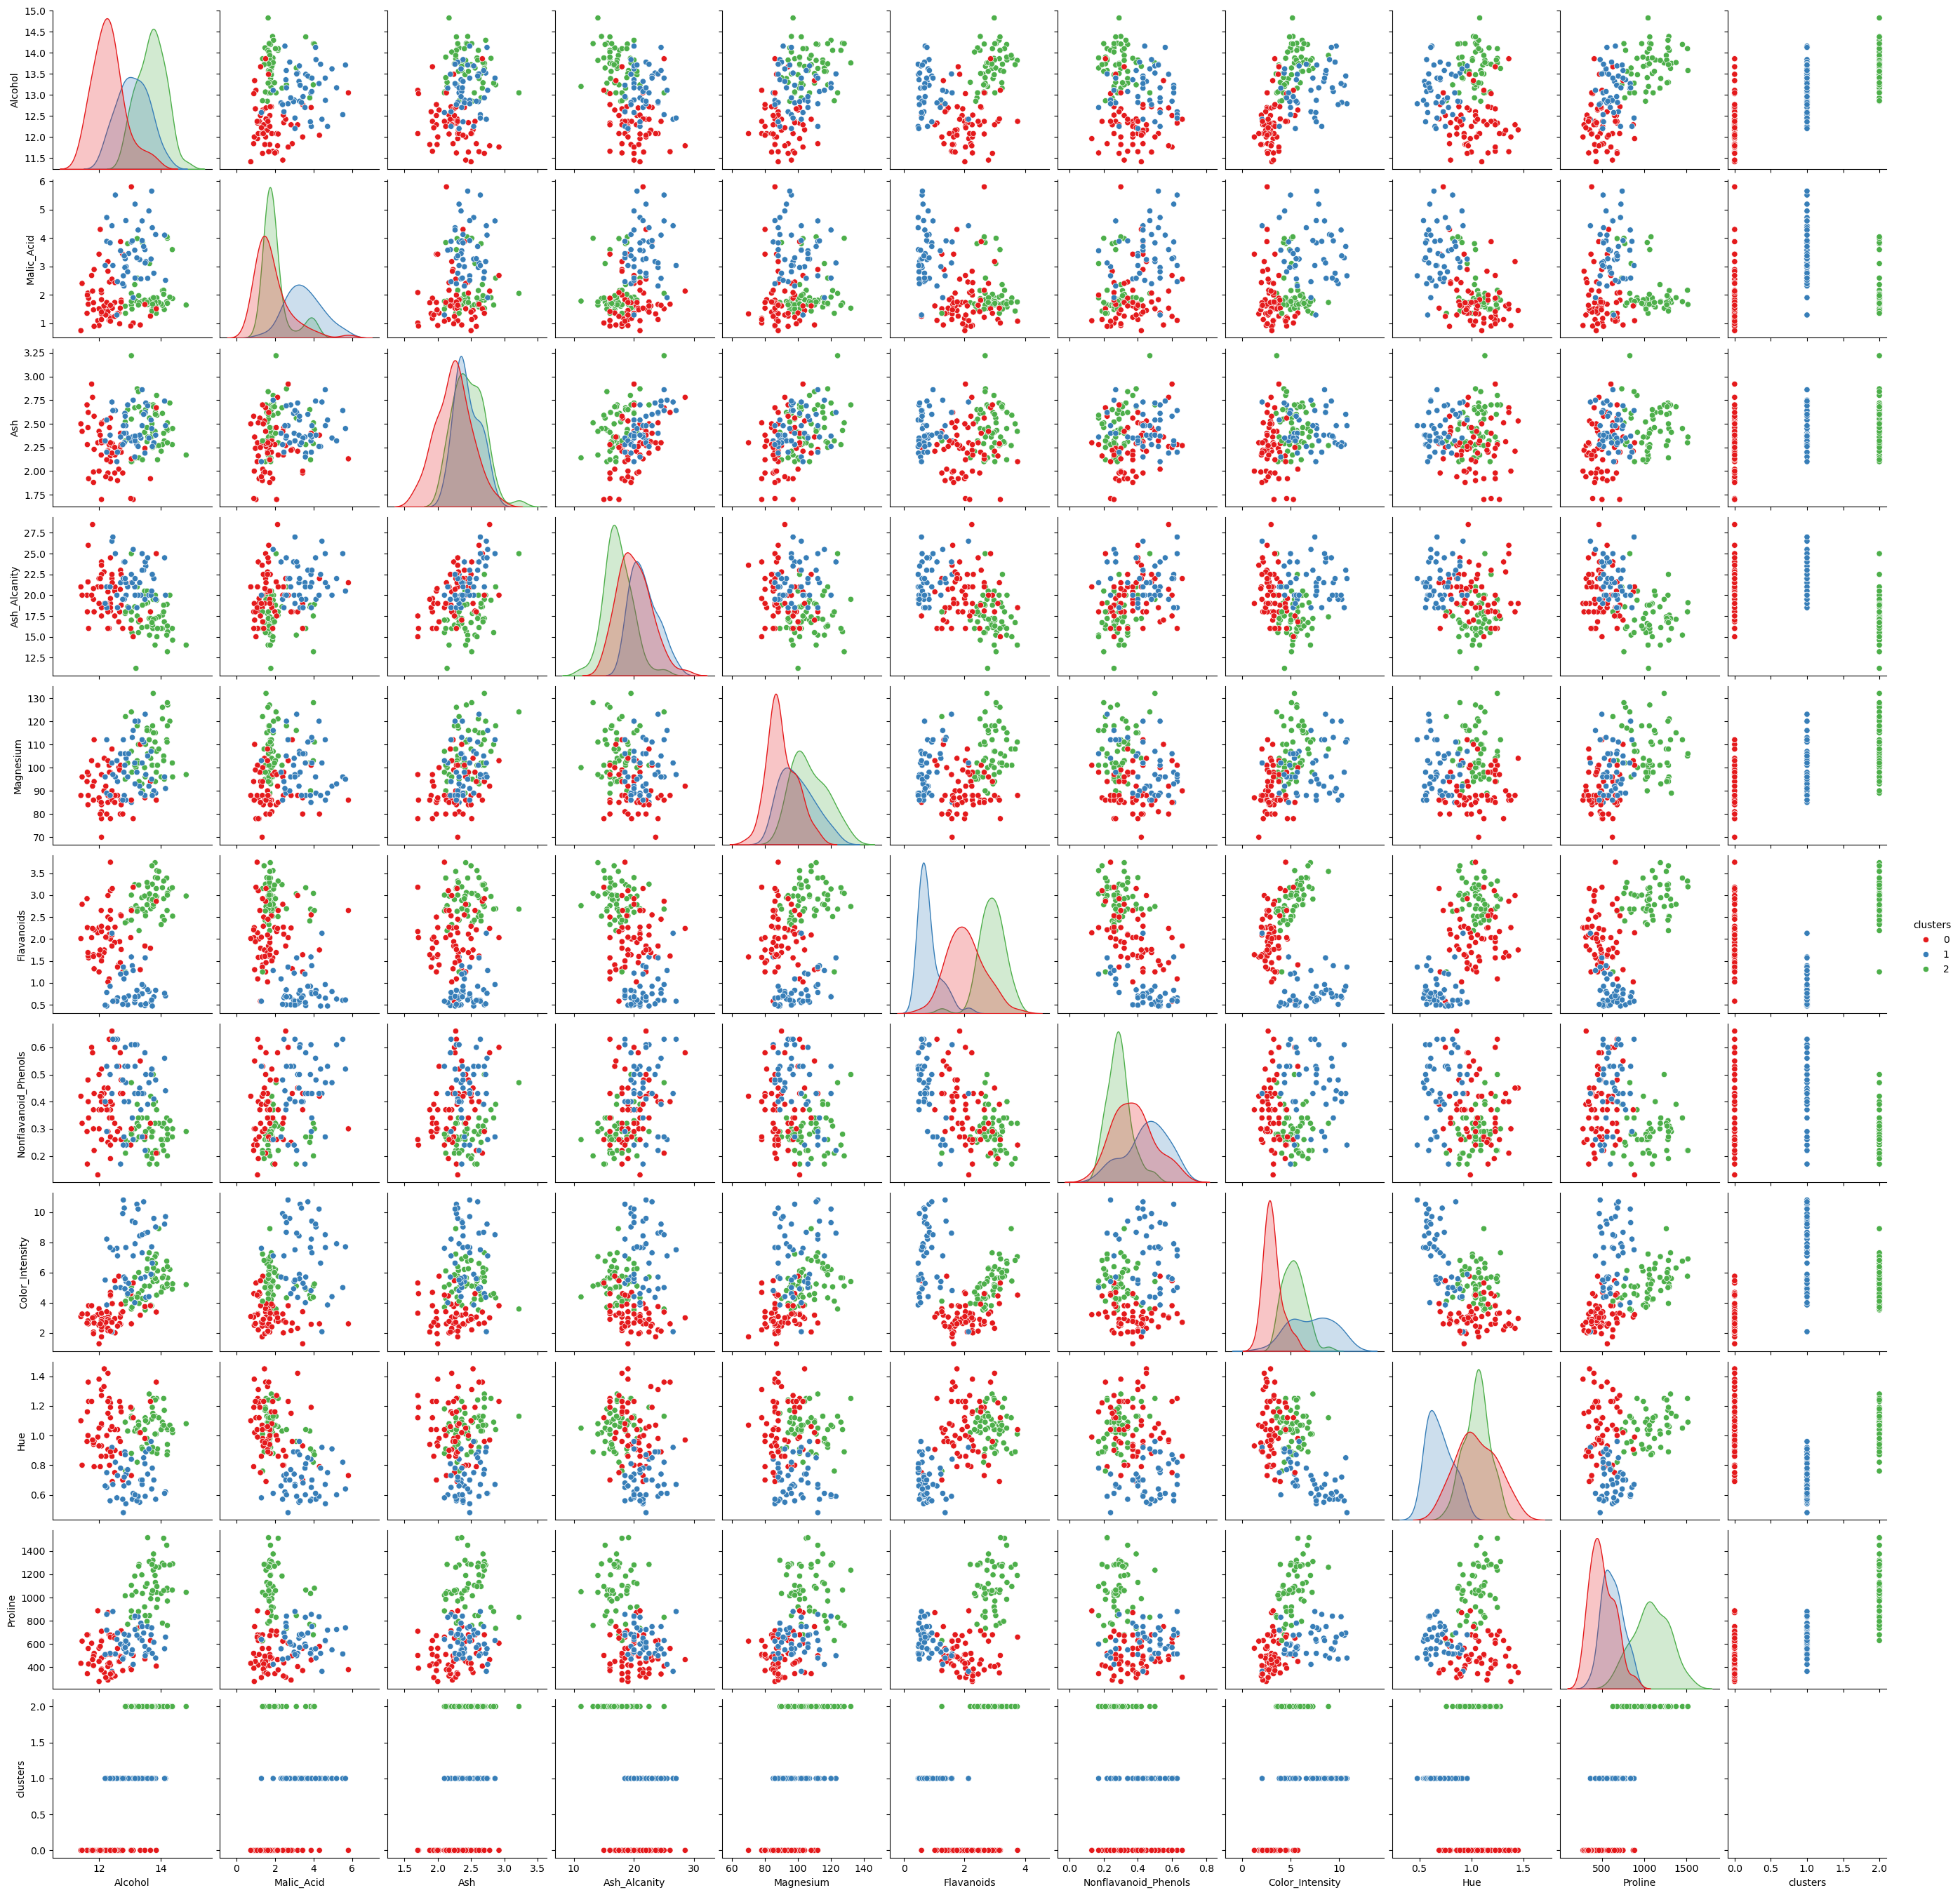

In [43]:
sns.pairplot(df_exp_two, 
             vars=df_exp_two.columns, 
             hue='clusters',
             diag_kind='kde',
             palette='Set1'
             )

plt.show()

### Task 5: Interpretation
- Interpret the characteristics of each cluster. For example, identify which cluster has the highest alcohol content, or which has the most intense color, etc.
- Suggest potential names or categories for each cluster based on the observed characteristics.


In [44]:
mean_of_clusters

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Flavanoids,Nonflavanoid_Phenols,Color_Intensity,Hue,Proline
clusters,,,,,,,,,,
0,12.312167,1.835500,2.239,20.036667,90.133333,2.031500,0.375000,3.124500,1.050600,505.100000
1,13.106222,3.496222,2.442,21.644444,99.555556,0.814444,0.450222,7.171111,0.695556,625.333333
2,13.692000,2.020182,2.462,17.347273,107.090909,2.894364,0.288545,5.339455,1.050182,1080.909091


In [ ]:
# Finding the Highly contaminated contents from the Wine Samples
for i in mean_of_clusters.columns:
    highly_contaminated_cluster = mean_of_clusters[i].idxmax()
    highest_value = mean_of_clusters[i].max()
    print(f'Cluster {highly_contaminated_cluster} : Highly Contaminated -> {i}, mean = {round(highest_value, 2)}')

Cluster 2 : Highly Contaminated -> Alcohol, mean = 13.69
Cluster 1 : Highly Contaminated -> Malic_Acid, mean = 3.5
Cluster 2 : Highly Contaminated -> Ash, mean = 2.46
Cluster 1 : Highly Contaminated -> Ash_Alcanity, mean = 21.64
Cluster 2 : Highly Contaminated -> Magnesium, mean = 107.09
Cluster 2 : Highly Contaminated -> Flavanoids, mean = 2.89
Cluster 1 : Highly Contaminated -> Nonflavanoid_Phenols, mean = 0.45
Cluster 1 : Highly Contaminated -> Color_Intensity, mean = 7.17
Cluster 0 : Highly Contaminated -> Hue, mean = 1.05
Cluster 2 : Highly Contaminated -> Proline, mean = 1080.91


Alcohol


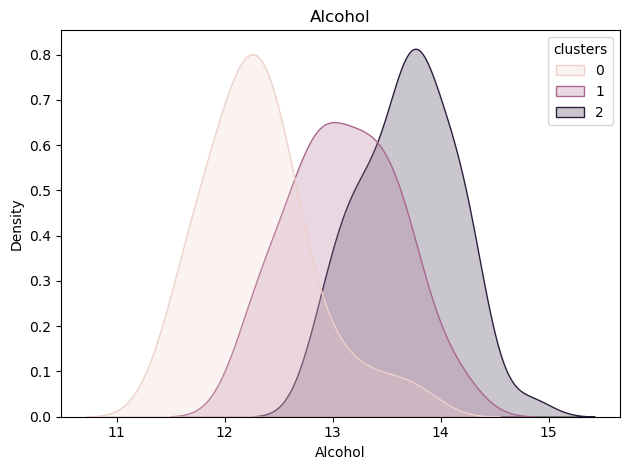

Malic_Acid


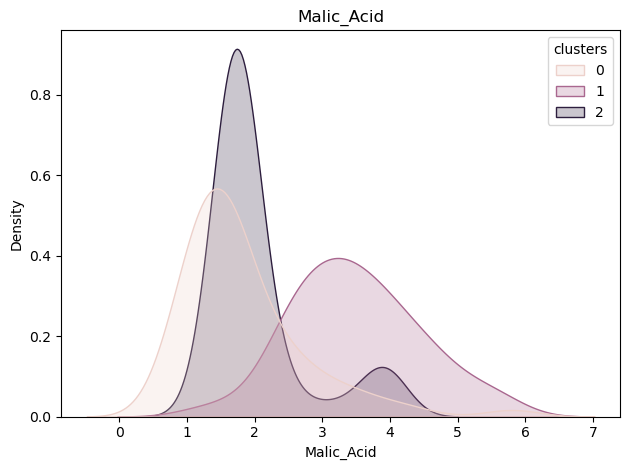

Ash


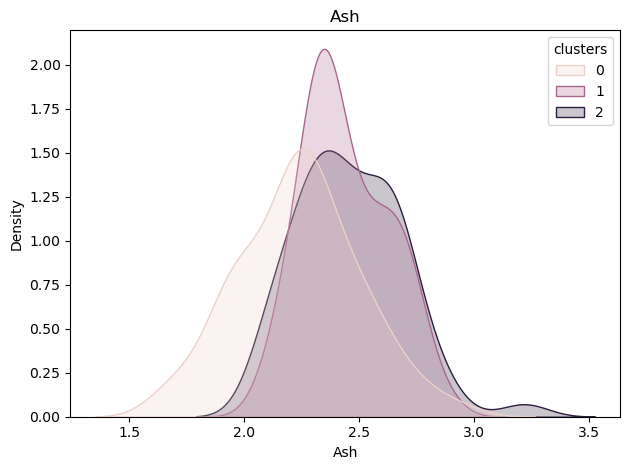

Ash_Alcanity


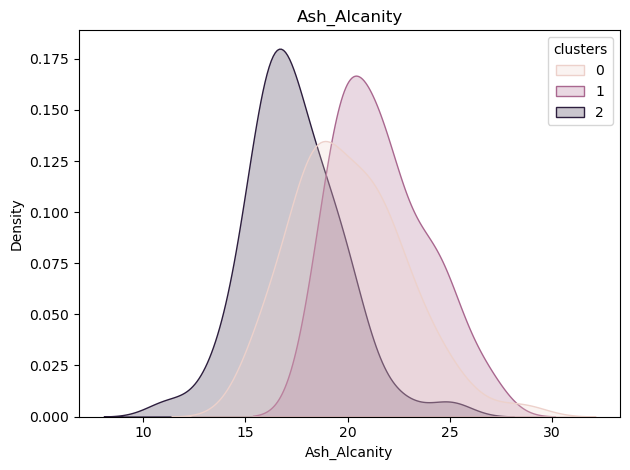

Magnesium


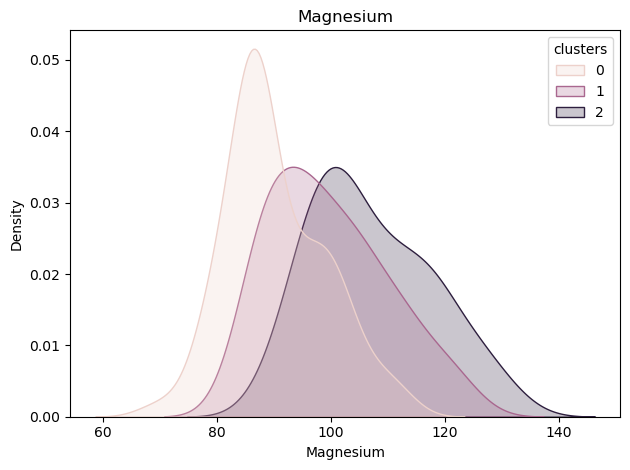

Flavanoids


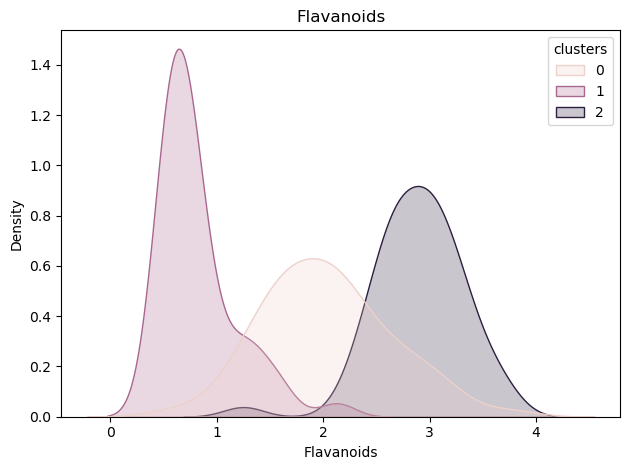

Nonflavanoid_Phenols


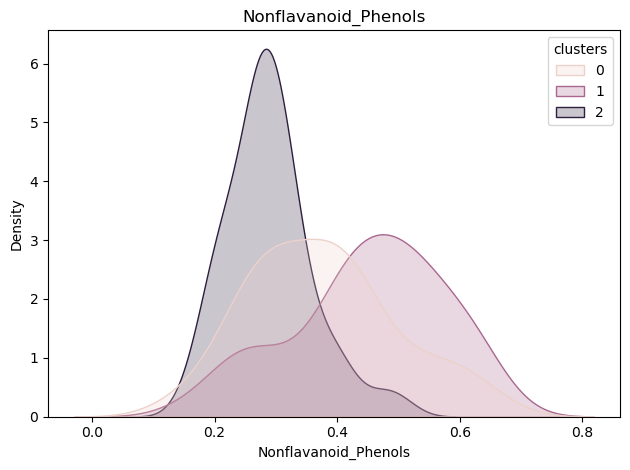

Color_Intensity


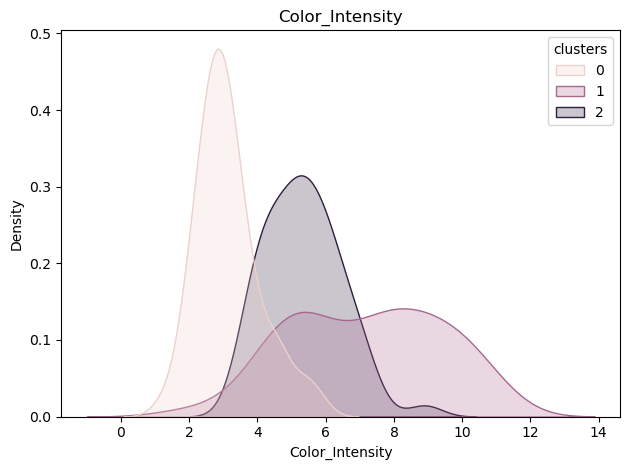

Hue


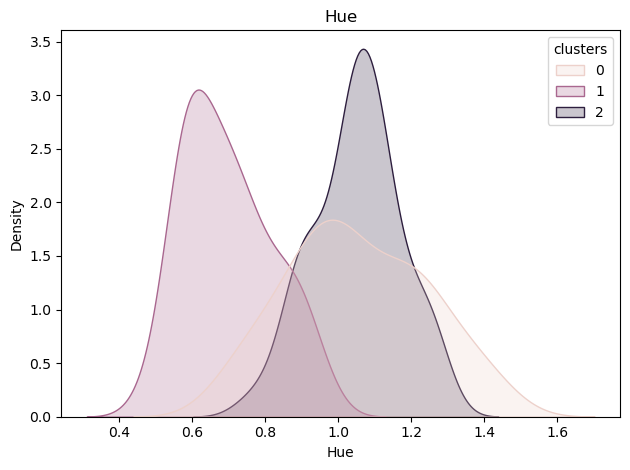

Proline


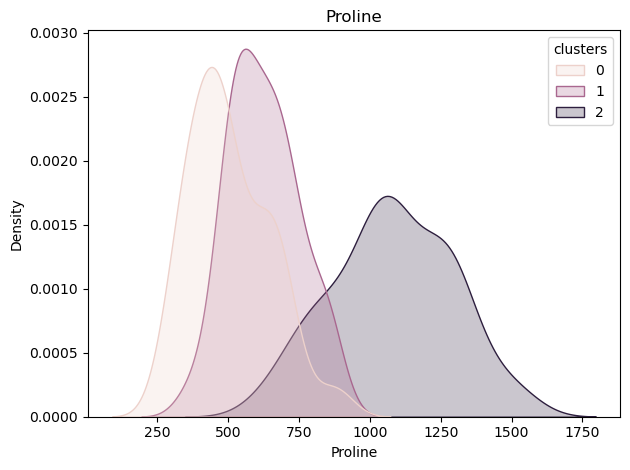

In [ ]:
# KDE plot for visualizing the Normal Distributions of each Features to each Clusters
for i in mean_of_clusters.columns:
    print(i)
    sns.kdeplot(data=df_exp_two, x=i, hue='clusters', fill=True, common_norm=False)
    plt.title(f"{i}")
    plt.tight_layout()
    plt.show()
